In [2]:
import explore
import pandas as pd
import numpy as np
import env
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import acquire
import prepare
import wrangle
import warnings
warnings.filterwarnings("ignore")


import scipy.stats as stats
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression


In [3]:
train, validate, test = wrangle.wrangle_zillow()

In [4]:
train.shape, validate.shape, test.shape

((25908, 17), (8637, 17), (8637, 17))

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25908 entries, 50660 to 34188
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   parcelid      25908 non-null  int64  
 1   bathrooms     25908 non-null  float64
 2   bedrooms      25908 non-null  float64
 3   sqft          25908 non-null  float64
 4   county        25908 non-null  object 
 5   fireplacecnt  25908 non-null  float64
 6   garagecarcnt  25908 non-null  float64
 7   lotsize       25908 non-null  float64
 8   poolcnt       25908 non-null  float64
 9   logerror      25908 non-null  float64
 10  tract         25908 non-null  int64  
 11  tax_value     25908 non-null  float64
 12  Orange        25908 non-null  uint8  
 13  Ventura       25908 non-null  uint8  
 14  age           25908 non-null  float64
 15  4plusBath     25908 non-null  int64  
 16  3to5garage    25908 non-null  int64  
dtypes: float64(10), int64(4), object(1), uint8(2)
memory usage: 3.2+ 

In [6]:
train.describe().apply(lambda s: s.apply('{0:.2f}'.format)).T

,count,mean,std,min,25%,50%,75%,max
parcelid,25908.00,13007162.00,2586803.24,10711855.00,11503757.75,12653312.50,14128263.25,162960814.00
bathrooms,25908.00,2.13,0.77,0.00,2.00,2.00,2.50,5.50
bedrooms,25908.00,3.23,0.86,0.00,3.00,3.00,4.00,6.00
sqft,25908.00,1722.17,666.84,128.00,1240.00,1573.00,2073.00,5256.00
fireplacecnt,25908.00,0.16,0.42,0.00,0.00,0.00,0.00,4.00
garagecarcnt,25908.00,0.67,0.94,0.00,0.00,0.00,2.00,9.00
lotsize,25908.00,7160.42,3127.55,236.00,5457.00,6624.00,8039.00,21663.00
poolcnt,25908.00,0.18,0.39,0.00,0.00,0.00,0.00,1.00
logerror,25908.00,0.02,0.16,-4.66,-0.02,0.01,0.04,3.18
tract,25908.00,3050.57,2821.20,2.00,746.00,1955.00,5300.00,9800.00


In [7]:
train['4plusBR'] = np.where(train['bedrooms'] > 3, 1, 0)
train['4plusBath'] = np.where(train['bathrooms'] > 3,1,0)
train['3to5garage'] = np.where((train['garagecarcnt'] > 2) & (train['garagecarcnt'] < 6), 1,0)
train['fpover2'] = np.where(train['fireplacecnt'] > 2,1,0)

In [8]:
train.head()

,parcelid,bathrooms,bedrooms,sqft,county,fireplacecnt,garagecarcnt,lotsize,poolcnt,logerror,tract,tax_value,Orange,Ventura,age,4plusBath,3to5garage,4plusBR,fpover2
50660,13016419,2.0,4.0,1444.0,Los Angeles,0.0,0.0,7490.0,1.0,-0.010825,4300,64364.0,0,0,58.0,0,0,1,0
14557,12331197,2.0,3.0,1545.0,Los Angeles,0.0,0.0,8807.0,0.0,-0.022325,5508,81549.0,0,0,71.0,0,0,0,0
47007,13939349,3.0,4.0,2286.0,Orange,0.0,2.0,8400.0,0.0,0.015910,758,330190.0,1,0,57.0,0,0,1,0
26586,17209964,2.0,3.0,1431.0,Ventura,1.0,2.0,11100.0,0.0,0.006926,66,564363.0,0,1,59.0,0,0,0,0
50383,14411957,2.5,3.0,1463.0,Orange,0.0,2.0,4400.0,0.0,-0.003318,423,330797.0,1,0,29.0,0,0,0,0


In [9]:
#explore.plot_variable_pairs(train)
cols = ['bedrooms',  'bathrooms','yearbuilt', 'tract',
            'sqft', 'lotsize', 'tax_value']
    
    
# make correlation plot
df_corr = train[cols].corr()
plt.figure(figsize=(12,8))
sns.heatmap(df_corr, cmap='Blues', annot = True, mask= np.triu(df_corr), linewidth=.5)
plt.show()

KeyError: "['yearbuilt'] not in index"

### sqft is highly correlated with br and bathroom count - may not want to use them all for modeling

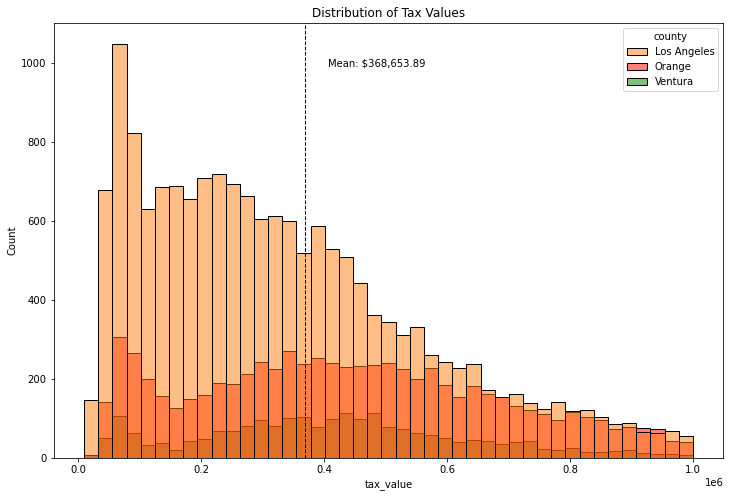

In [10]:
# Plot Distribution of target variable
plt.figure(figsize=(12,8))
plt.title('Distribution of Tax Values')
sns.histplot(data=train, x='tax_value', hue='county', palette=["C1", "red", "green"])
plt.axvline(train.tax_value.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(train.tax_value.mean()*1.1, max_ylim*0.9, 'Mean: ${:,.2f}'.format(train.tax_value.mean()))
plt.show()

# data is positively (right) skewed.  Will want to transform prior to modeling


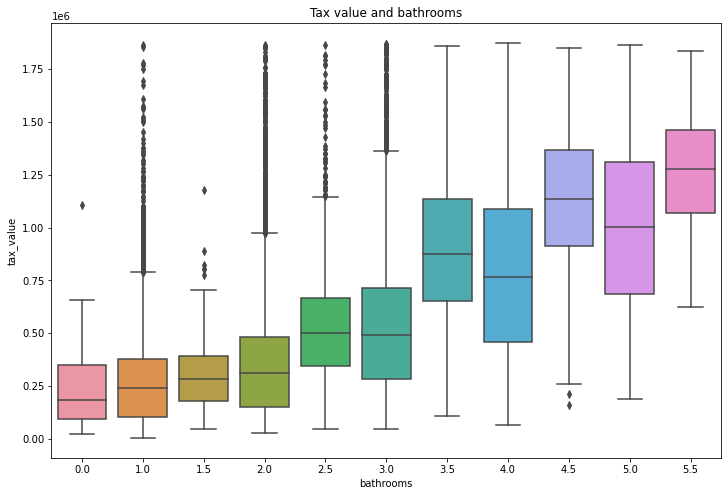

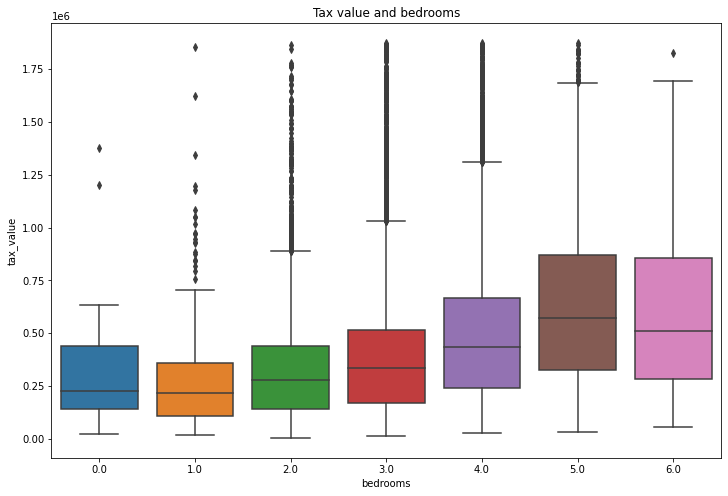

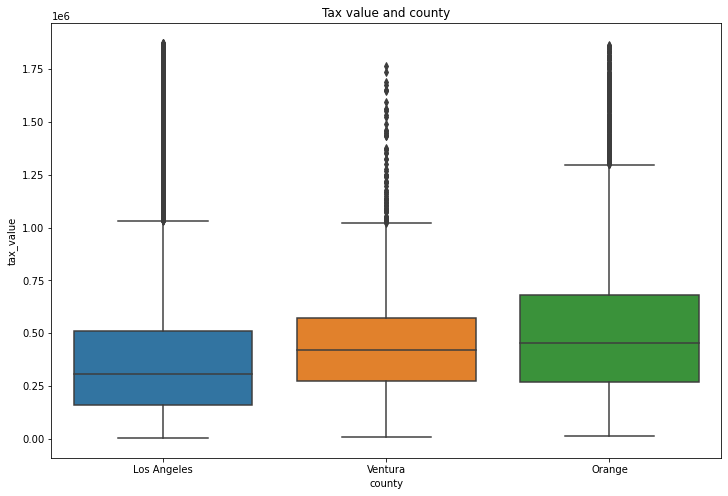

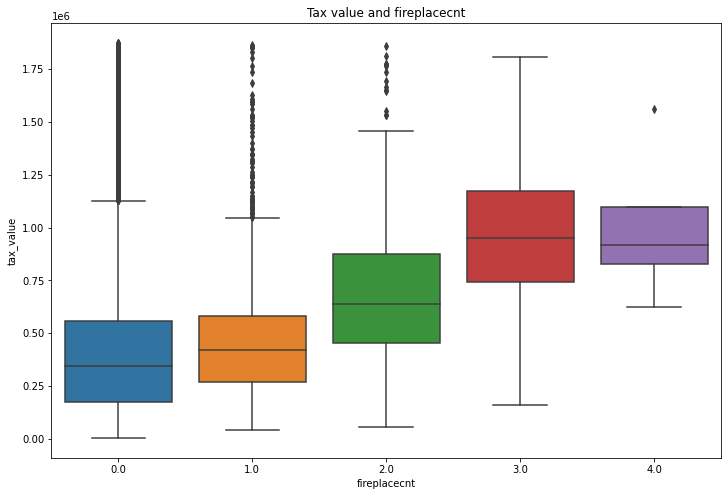

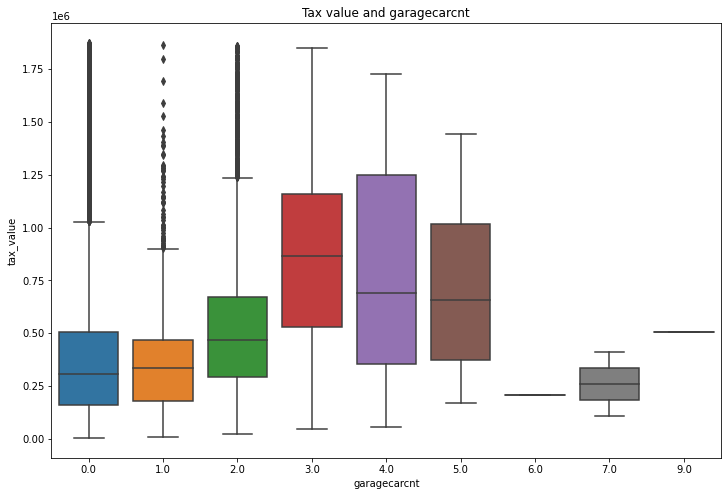

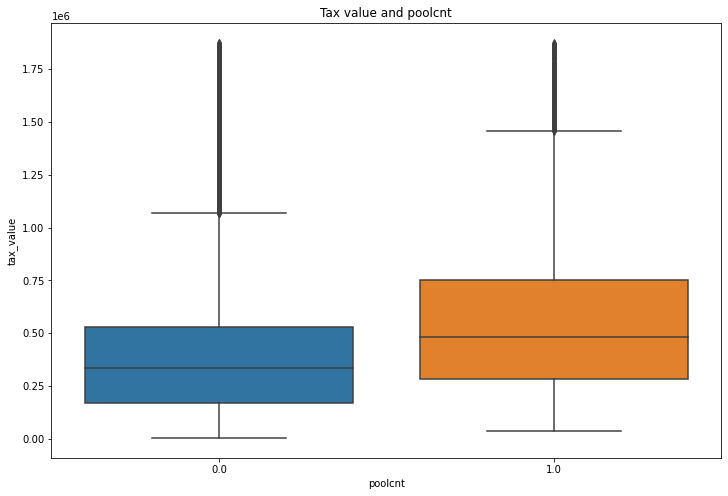

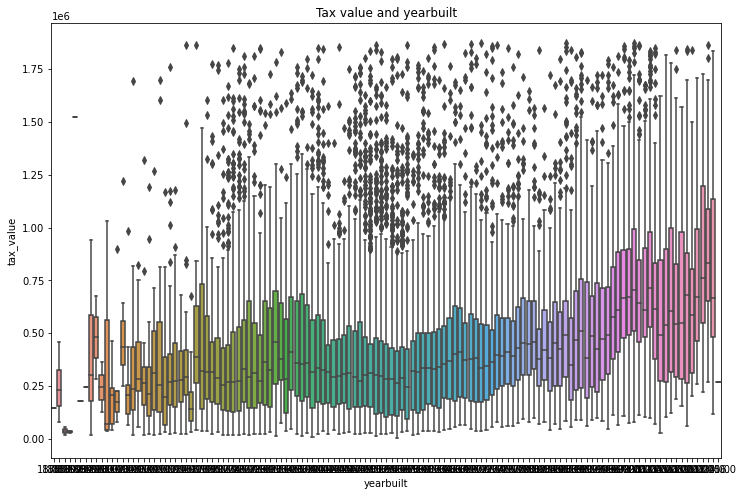

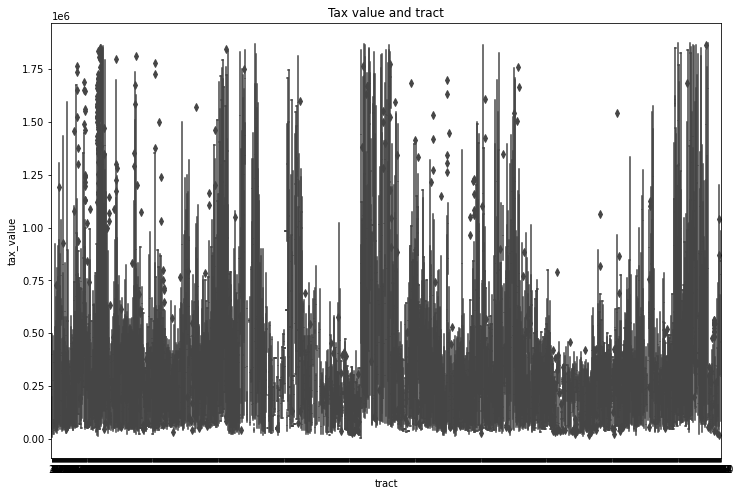

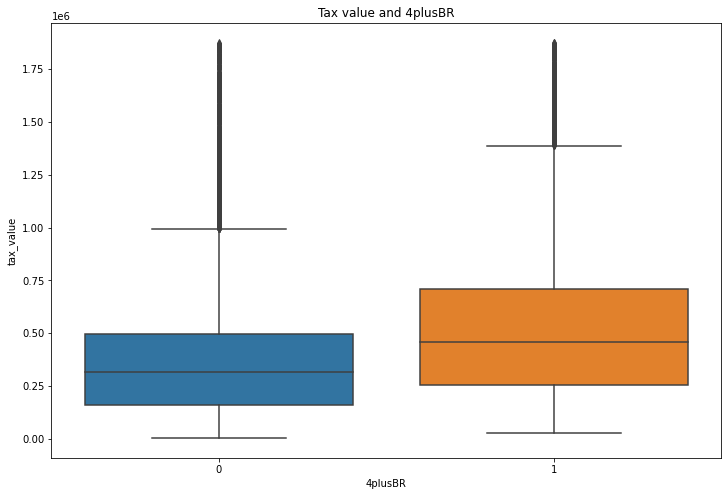

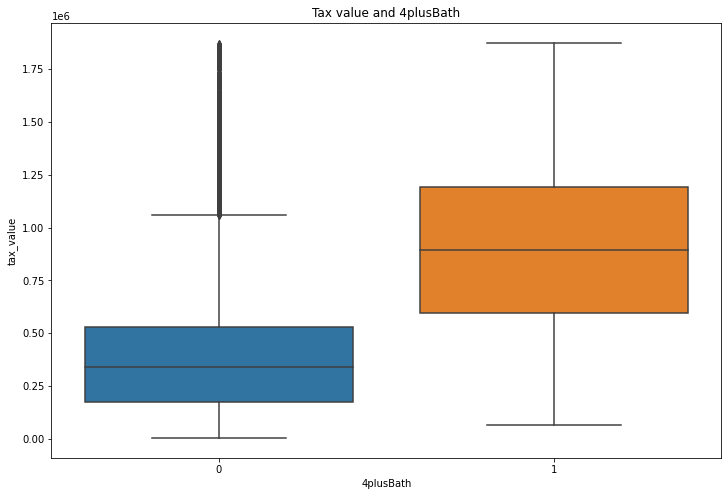

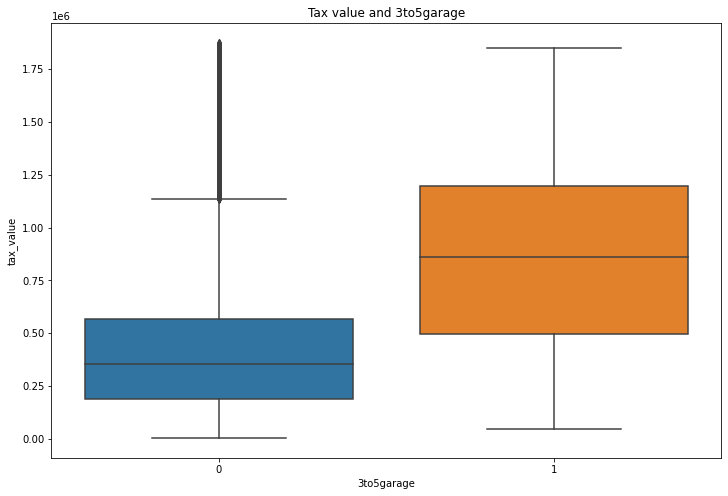

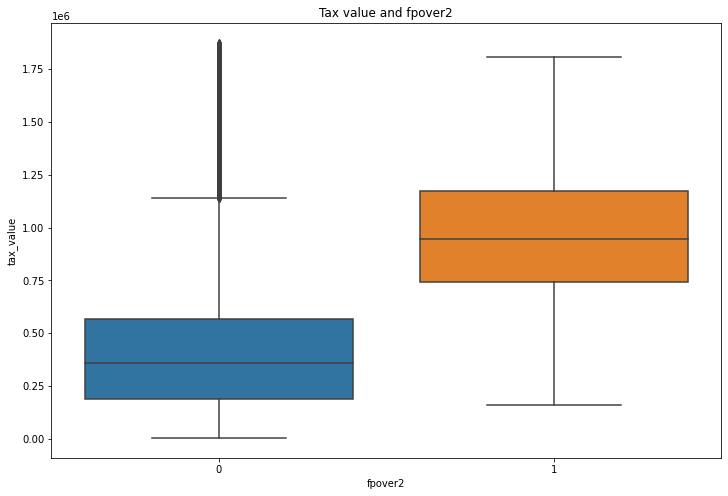

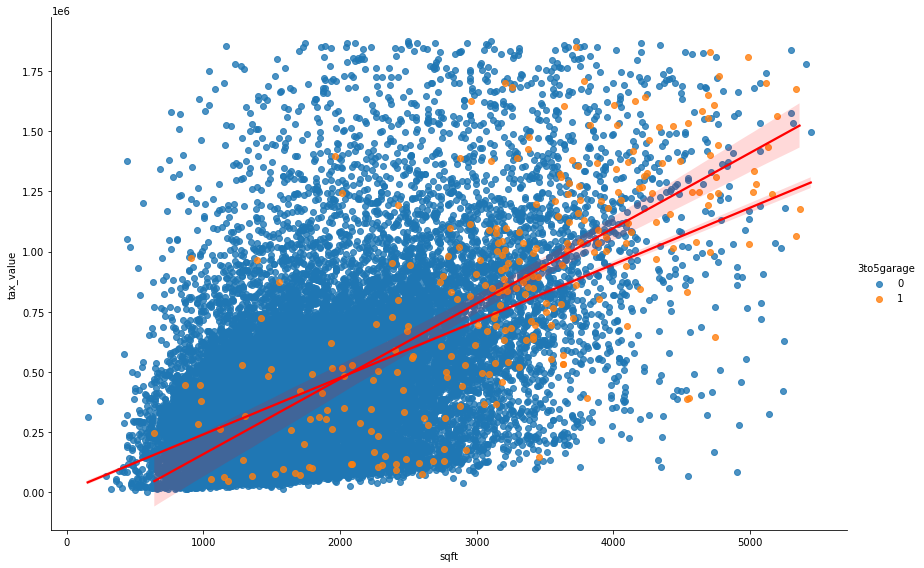

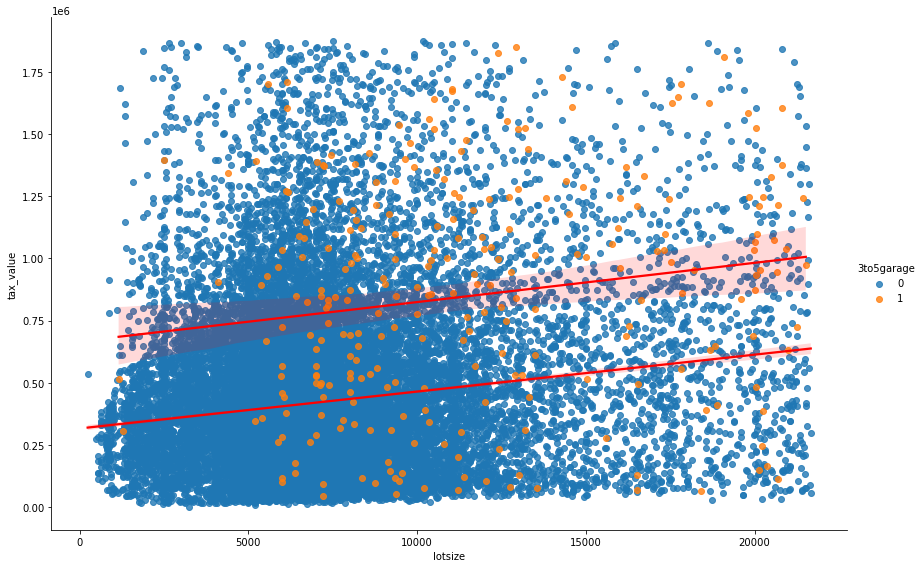

In [10]:
cat_vars = ['bathrooms', 'bedrooms', 'county', 'fireplacecnt', 'garagecarcnt', 
            'poolcnt', 'yearbuilt', 'tract', '4plusBR', '4plusBath', '3to5garage', 'fpover2']
num_vars = ['sqft', 'lotsize']

for cat in cat_vars:
    plt.figure(figsize=(12,8))
    plt.title(f'Tax value and {cat}')
    sns.boxplot(data=train, y='tax_value', x=cat)
    plt.show()
    
for num in num_vars:
    sns.lmplot(data=train, y='tax_value', x=num, height=8, aspect=12/8, hue='3to5garage',line_kws={'color':'red'})
    plt.show()

In [ ]:
v.hashottuborspa.value_counts(), v.poolcnt.value_counts()

In [ ]:
o.hashottuborspa.value_counts(), o.poolcnt.value_counts()

In [ ]:
l.hashottuborspa.value_counts(), l.poolcnt.value_counts()

## Orange county is the only county with counts for hot tub/spa.  Will need to drop that column for final notebook

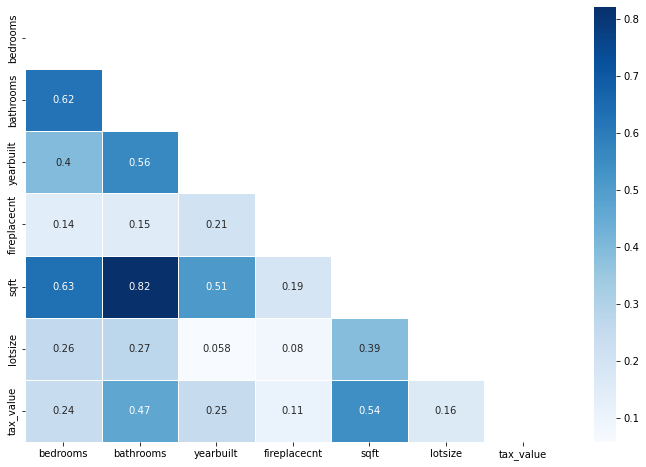

In [11]:
# test correlation plot function
explore.corr_plot(train)

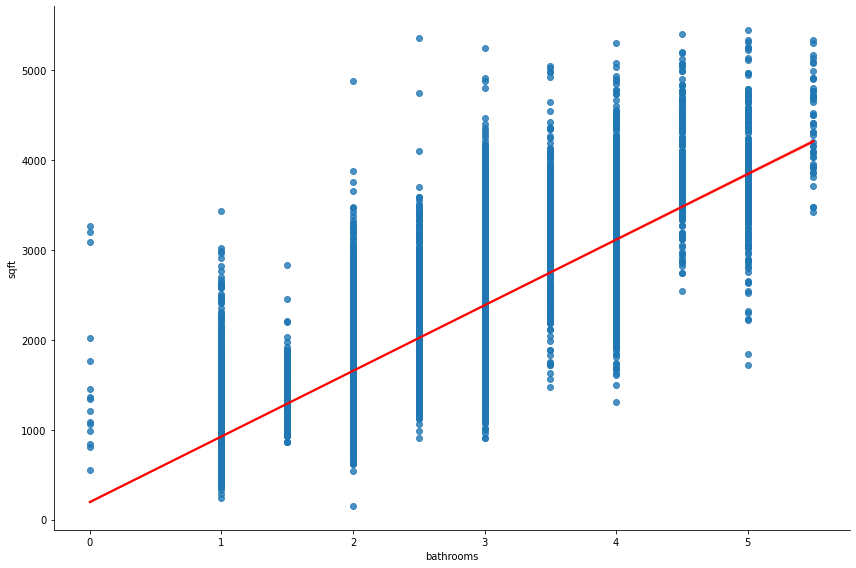

In [12]:
sns.lmplot(data=train, y='sqft', x='bathrooms', height=8, aspect=12/8,line_kws={'color':'red'})
plt.show()

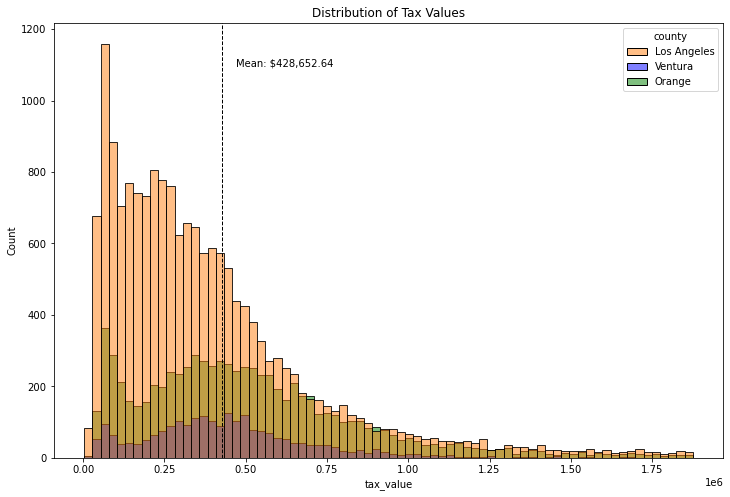

In [13]:
# test target variable distribution plot
explore.target_dist(train)

In [14]:
def rfe(X, y, num):
    model = LinearRegression()
    # make the rfe
    rfe = RFE(model, n_features_to_select=num)
    # fit the rfe
    rfe.fit(X, y)
    
    results = pd.DataFrame(
    {
        'rfe_ranking' : rfe.ranking_
    }, index = X.columns)
    print(results.index[results.rfe_ranking == 1].tolist())

In [15]:
X = train.drop(columns=['tax_value','county','logerror','parcelid','bathrooms','4plusBR','garagecarcnt'])
y = train.tax_value
rfe(X,y,10)

['bedrooms', 'sqft', 'fireplacecnt', 'yearbuilt', 'poolcnt', 'Orange', 'Ventura', '4plusBath', '3to5garage', 'fpover2']


In [16]:
def select_kbest(X, y, num):
    kbest = SelectKBest(score_func=f_regression, k=num)
    kbest.fit(X, y) 
    
    return X.columns[kbest.get_support()].tolist()

In [17]:
select_kbest(X,y,5)

['bedrooms', 'sqft', 'yearbuilt', 'poolcnt', '4plusBath']

In [18]:
train.bedrooms.value_counts()

3.0    12788
4.0     8013
2.0     4572
5.0     1800
1.0      284
6.0      222
0.0       17
Name: bedrooms, dtype: int64

In [19]:
from IPython.display import display_html 

def correlation_report(df, target):
    '''
    Function to display two side-by-side dataframes of correlation data for the value of churn
    The table on the left shows the top 11 columns by highest absolute value of correlation
    The table on the right shows the top 11 columns by lowest absolute value of correlation
    The #1 correlated column will be the target with itself (value = 1) and is omitted

    function accepts a dataframe 
    '''
    corr = abs(df.corr()[[target]]).sort_values(by=target, ascending=False)
    corr.rename(columns={'tax_value' : 'Correlation'}, inplace=True)
    corr1 = corr.iloc[1:8]
    corr2 = corr.iloc[:8:-1]
    df1_style = corr1.style.set_table_attributes("style='display:inline; margin-right:100px;'").set_caption("Most Correlation")
    df2_style = corr2.style.set_table_attributes("style='display:inline'").set_caption("Least Correlation")

    display_html(df1_style._repr_html_() + df2_style._repr_html_(), raw=True)

In [20]:
correlation_report(train, target='tax_value')

,Correlation
sqft,0.542336
bathrooms,0.467170
4plusBath,0.400526
yearbuilt,0.246025
bedrooms,0.243676
4plusBR,0.223276
poolcnt,0.199226
,Correlation
Ventura,0.017007
logerror,0.018756


In [98]:
def county_plot(df):
   
    # create subsets of df for each county
    orange = df[df.county == 'Orange']
    ventura = df[df.county == 'Ventura']
    la = df[df.county == 'Los Angeles']

    # get baseline value rate for the horizontal line
    baseline = df.tax_value.mean()

    # display factorplot

    p = sns.factorplot( x="county", y="tax_value",  data=df, size=5, 
                   aspect=2, kind="bar", palette="muted", ci=None,
                   edgecolor=".2")


    
    plt.axhline(baseline, label = 'overall average property value', ls='--')
    p.set_ylabels("Property Value")
    p.set_xlabels("County")
    plt.title('Does County affect property value?')
    plt.show()
    # output values in each county
    print('Average property value of those in Los Angeles County is ', "${:,}".format(int(la.tax_value.mean())))
    print('Average property value of those in Ventura County is', "${:,}".format(int(ventura.tax_value.mean())))
    print('Average property value of those in Orange County is', "${:,}".format(int(orange.tax_value.mean())))
    print("")
    print("")

def county_ANOVA(df):
    orange = df[df.county == 'Orange']
    ventura = df[df.county == 'Ventura']
    la = df[df.county == 'Los Angeles']


    alpha = .05
    f, p = stats.f_oneway(orange.tax_value, ventura.tax_value, la.tax_value) 
    if p < alpha:
        print("We reject the Null Hypothesis")
    else:
        print("We confirm the Null Hypothesis")

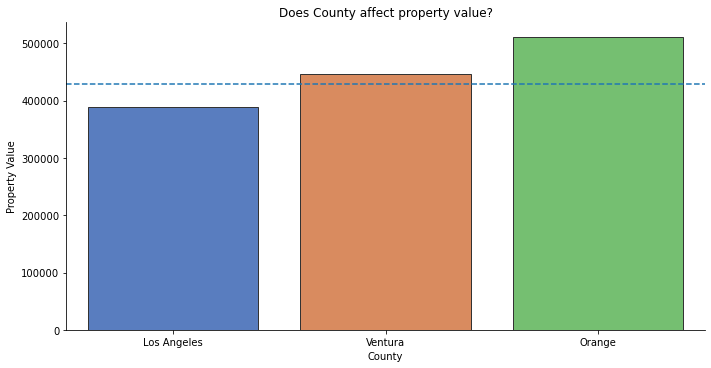

Average property value of those in Los Angeles County is  $389,439
Average property value of those in Ventura County is $447,007
Average property value of those in Orange County is $511,054




In [21]:
explore.county_plot(train)

H0: tax value means of the properties in three counties (Los Angeles, Ventura, and Orange) are all equal.

Ha: tax value means of the properties in three counties (Los Angeles, Ventura, and Orange) are NOT all equal

In [22]:
explore.county_ANOVA(train)

We reject the Null Hypothesis


In [119]:
def manybath_plot(df):
    '''
    Function to display a factor plot with the rate of churn for customers that do and do not
    have internet service 
    '''
    # create subsets of df for those with/without internet service
    yes = df[df['4plusBath'] == 1].tax_value.mean()
    no = df[df['4plusBath'] == 0].tax_value.mean()
    
    # get baseline churn rate for the horizontal line
    baseline = df.tax_value.mean()

    # display factorplot

    p = sns.factorplot( x="4plusBath", y="tax_value",  data=df, size=5, 
                   aspect=2, kind="bar", palette="muted", ci=None,
                   edgecolor=".2")


    
    plt.axhline(baseline, label = 'overall average property value', ls='--')
    p.set_ylabels("Property Value")
    p.set_xlabels("Has more than Three Bathrooms")
    plt.title('Do Lots of Bathrooms affect Tax Value?')
    plt.show()
    # output values in each county
    print('Average property value of properties with more than three bathrooms ', "${:,}".format(round(yes)))
    print('Average property value of properties with less than three bathrooms', "${:,}".format(round(no)))
    print("")

909546.8931337119


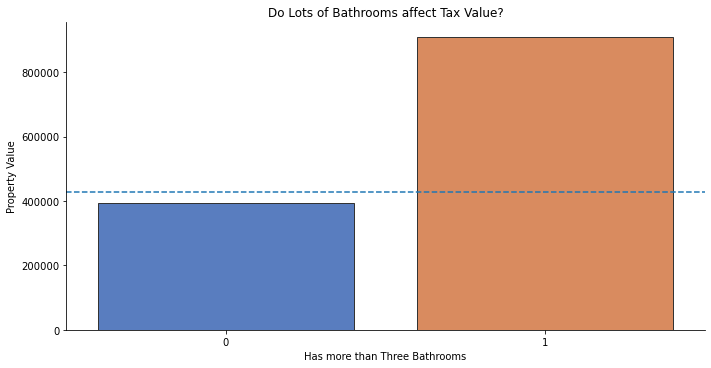

Average property value of properties with more than three bathrooms  $909,547
Average property value of properties with less than three bathrooms $392,491



In [23]:
explore.manybath_plot(train)

In [128]:
# Perform Independent T-Test: 2 samples, normal distribution, test variance

def manybath_test(df):
    yes = df[df['4plusBath'] == 1]
    no = df[df['4plusBath'] == 0]

    variance = yes.tax_value.var() == no.tax_value.var()
    α = .05
    t, p = stats.ttest_ind(yes.tax_value, no.tax_value, equal_var=variance)
    if p < α:
        print('We reject the null hypothesis.')
    else:
        print('The null hypothesis is confirmed')

In [24]:
explore.manybath_test(train)

We reject the null hypothesis.
